In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Cas12')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Layer, GlobalAveragePooling1D, AveragePooling1D, Input, Dense, Dropout, Activation, Flatten, Conv1D
from keras.layers import MultiHeadAttention, LayerNormalization, Bidirectional, LSTM, SimpleRNN
from keras import Model
from keras.metrics import MeanSquaredError
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib

!pip install GPyOpt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 17.4 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=0f9a2b9d1610e615261ae2367f0e474c4dbcb28300463c1d68ee2eff729dca3f
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


### Data preparation

In [ ]:
def PREPROCESS_withoutCA(lines):
    data_n = len(lines) - 1
    SEQ = np.zeros((data_n, 34, 4), dtype=int)
    label = np.zeros((data_n, 1, 1))

    for l in range(1, data_n + 1):
        data = lines[l].split(',')

        y = float(data[2])
        if y < 0:
            label[l - 1, 0, 0] = 0
        else:
            label[l - 1, 0, 0] = y

        seq = data[1]
        for i in range(34):
            if seq[i] in "Aa":
                SEQ[l - 1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l - 1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l - 1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l - 1, i, 3] = 1

    return SEQ, label

FILE = open('/content/drive/MyDrive/Colab Notebooks/Cas12/data/input_HT-1-1.csv', "r")
data = FILE.readlines()
Seq, Target = PREPROCESS_withoutCA(data)
FILE.close()
print(f'X_train shape: {Seq.shape}\ny_train shape: {Target.shape}')

X_train shape: (15000, 34, 4)
y_train shape: (15000, 1, 1)


### Hyperparameter optimization for CNN+SimpleRNN

In [ ]:
def SimpleRNN_model(input_shape, num_filter, kernel_size, dropout_rate, rnn_unit, dense1_unit, dense2_unit, dense3_unit):
    input = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(input)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate)(pool2)

    srnn1 = SimpleRNN(rnn_unit,
                      dropout=dropout_rate,
                      activation="tanh",
                      return_sequences=True,
                      kernel_regularizer=regularizers.l2(0.01))(drop2)
    srnn2 = SimpleRNN(rnn_unit,
                      dropout=dropout_rate,
                      activation="tanh",
                      return_sequences=True,
                      kernel_regularizer=regularizers.l2(0.01))(srnn1)
    avgpool = GlobalAveragePooling1D()(srnn2)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate)(dense3)

    output = Dense(1, activation='linear')(drop5)
    model = Model(inputs=[input], outputs=[output])

    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate = args[0][4]
    rnn_unit = int(args[0][5])
    dense1_unit = int(args[0][6])
    dense2_unit = int(args[0][7])
    dense3_unit = int(args[0][8])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\trnn_unit:{rnn_unit}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = Target[train_index], Target[val_index]

        model = SimpleRNN_model((34,4), num_filter, kernel_size, dropout_rate, rnn_unit, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation loss:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
rnn_unit_domain = [4, 8, 16, 32, 64, 128]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout", "type": "discrete", "domain": dropout_domain},
    {"name": "rnn_unit", "type": "discrete", "domain": rnn_unit_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

learning_rate:0.001	batch_size:512	num_filter:512	kernel_size:5	dropout_rate:0.4	rnn_unit:8	dense1_unit:4	dense2_unit:8	dense3_unit:256
Start training...
Avg validation loss: 726.1450668334961
learning_rate:0.001	batch_size:32	num_filter:256	kernel_size:3	dropout_rate:0.2	rnn_unit:4	dense1_unit:4	dense2_unit:128	dense3_unit:8
Start training...
Avg validation loss: 535.1856536865234
learning_rate:0.0001	batch_size:32	num_filter:256	kernel_size:3	dropout_rate:0.2	rnn_unit:8	dense1_unit:32	dense2_unit:512	dense3_unit:512
Start training...
Avg validation loss: 458.4687774658203
learning_rate:0.0001	batch_size:64	num_filter:128	kernel_size:5	dropout_rate:0.2	rnn_unit:32	dense1_unit:512	dense2_unit:512	dense3_unit:512
Start training...
Avg validation loss: 420.57303009033205
learning_rate:0.0001	batch_size:32	num_filter:256	kernel_size:3	dropout_rate:0.3	rnn_unit:8	dense1_unit:8	dense2_unit:4	dense3_unit:32
Start training...
Avg validation loss: 600.0168548583985
learning_rate:0.01	batch_siz

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-04, 6.40e+01, 1.28e+02, 5.00e+00, 2.00e-01, 3.20e+01,
        5.12e+02, 5.12e+02, 5.12e+02]),
 420.57303009033205)

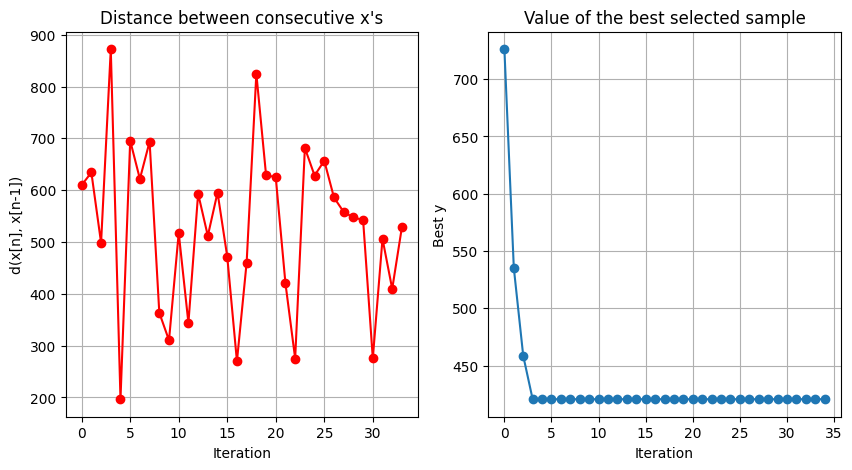

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for CNN+BiLSTM

In [ ]:
def BiLSTM_model(input_shape, num_filter, kernel_size, dropout_rate, lstm_unit, dense1_unit, dense2_unit, dense3_unit):
    inputs = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(inputs)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate)(pool2)

    lstm1 = Bidirectional(LSTM(lstm_unit,
                               dropout=dropout_rate,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(drop2)
    avgpool = GlobalAveragePooling1D()(lstm1)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate = args[0][4]
    lstm_unit = int(args[0][5])
    dense1_unit = int(args[0][6])
    dense2_unit = int(args[0][7])
    dense3_unit = int(args[0][8])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\tlstm_unit:{lstm_unit}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = Target[train_index], Target[val_index]

        model = BiLSTM_model((34,4), num_filter, kernel_size, dropout_rate, lstm_unit, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation loss:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm_unit_domain = [4, 8, 16, 32, 64, 128]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout", "type": "discrete", "domain": dropout_domain},
    {"name": "lstm_unit", "type": "discrete", "domain": lstm_unit_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

learning_rate:0.01	batch_size:256	num_filter:256	kernel_size:5	dropout_rate:0.4	lstm_unit:8	dense1_unit:16	dense2_unit:4	dense3_unit:16
Start training...
Avg validation loss: 959.7551086425781
learning_rate:0.01	batch_size:32	num_filter:128	kernel_size:5	dropout_rate:0.1	lstm_unit:32	dense1_unit:16	dense2_unit:32	dense3_unit:8
Start training...
Avg validation loss: 982.2028884887695
learning_rate:0.001	batch_size:32	num_filter:128	kernel_size:3	dropout_rate:0.1	lstm_unit:16	dense1_unit:32	dense2_unit:16	dense3_unit:32
Start training...
Avg validation loss: 448.5285217285156
learning_rate:0.0001	batch_size:256	num_filter:256	kernel_size:5	dropout_rate:0.3	lstm_unit:4	dense1_unit:16	dense2_unit:64	dense3_unit:4
Start training...
Avg validation loss: 910.6474014282227
learning_rate:0.01	batch_size:128	num_filter:512	kernel_size:5	dropout_rate:0.2	lstm_unit:16	dense1_unit:8	dense2_unit:256	dense3_unit:8
Start training...
Avg validation loss: 1052.5546661376952
learning_rate:0.01	batch_size

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-04, 2.56e+02, 1.28e+02, 5.00e+00, 1.00e-01, 1.28e+02,
        1.28e+02, 3.20e+01, 3.20e+01]),
 419.47946014404295)

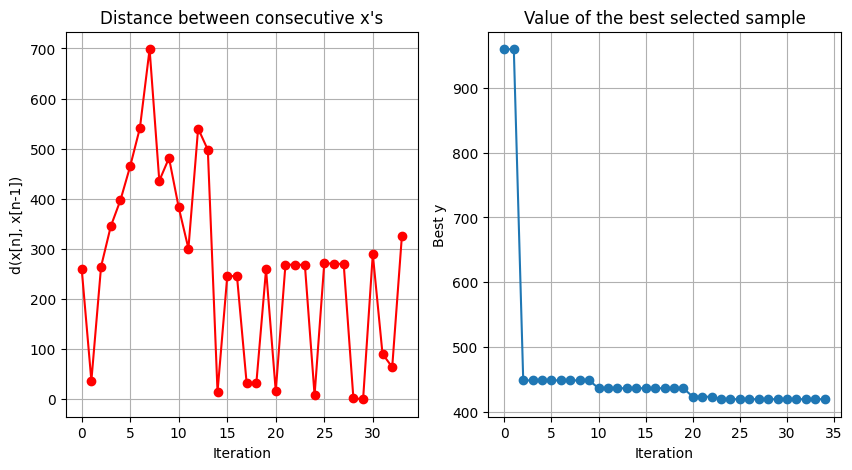

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for CNN+BiLSTM+MultiHeadAttention

In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_len=None, embedding_dim=None,**kwargs):
        super(PositionalEncoding, self).__init__()
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

    def call(self, x):

        position_embedding = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        position_embedding[:, 0::2] = np.sin(position_embedding[:, 0::2])  # dim 2i
        position_embedding[:, 1::2] = np.cos(position_embedding[:, 1::2])  # dim 2i+1
        position_embedding = tf.cast(position_embedding, dtype=tf.float32)

        return position_embedding+x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_len' : self.sequence_len,
            'embedding_dim' : self.embedding_dim,
        })
        return config

def MultiHeadAttention_model(input_shape, num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                             dropout_rate_dense, dropout_rate_attention, lstm_unit,
                             num_heads, key_dim, dense1_unit, dense2_unit, dense3_unit):
    input = Input(shape=input_shape)

    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(input)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    lstm = Bidirectional(LSTM(lstm_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(0.01)))(drop2)

    pos_embedding = PositionalEncoding(sequence_len=int(((34-kernel_size+1)/2-kernel_size+1)/2), embedding_dim=2*lstm_unit)(lstm)
    atten = MultiHeadAttention(num_heads=num_heads,
                               key_dim=key_dim,
                               dropout=dropout_rate_attention,
                               kernel_regularizer=regularizers.l2(0.01))(pos_embedding, pos_embedding)

    flat = Flatten()(atten)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(flat)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_lstm = args[0][5]
    dropout_rate_dense = args[0][6]
    dropout_rate_attention = args[0][7]
    lstm_unit = int(args[0][8])
    num_heads = int(args[0][9])
    key_dim = int(args[0][10])
    dense1_unit = int(args[0][11])
    dense2_unit = int(args[0][12])
    dense3_unit = int(args[0][13])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    #print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\tlstm_unit:{lstm_unit}\tnum_heads:{num_heads}\tkey_dim:{key_dim}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = Target[train_index], Target[val_index]

        model = MultiHeadAttention_model((34,4), num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                                         dropout_rate_dense, dropout_rate_attention, lstm_unit, num_heads,
                                         key_dim, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation MSE:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_lstm_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_attention_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm_unit_domain = [4, 8, 16, 32, 64, 128]
num_heads_domain = [2, 4, 6]
key_dim_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_lstm", "type": "discrete", "domain": dropout_lstm_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "dropout_rate_attention", "type": "discrete", "domain": dropout_attention_domain},
    {"name": "lstm_unit", "type": "discrete", "domain": lstm_unit_domain},
    {"name": "num_heads", "type": "discrete", "domain": num_heads_domain},
    {"name": "key_dim", "type": "discrete", "domain": key_dim_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation MSE: 1038.4175842285156
Start training...
Avg validation MSE: 632.6431121826172
Start training...
Avg validation MSE: 424.9266754150391
Start training...
Avg validation MSE: 857.3028564453125
Start training...
Avg validation MSE: 1049.0376525878905
Start training...
Avg validation MSE: 426.9916931152344
Start training...
Avg validation MSE: 924.4679809570313
Start training...
Avg validation MSE: 549.5188751220703
Start training...
Avg validation MSE: 865.8267517089844
Start training...
Avg validation MSE: 526.3969940185547
Start training...
Avg validation MSE: 984.2465850830079
Start training...
Avg validation MSE: 515.5312377929688
Start training...
Avg validation MSE: 1086.4401611328126
Start training...
Avg validation MSE: 907.442333984375
Start training...
Avg validation MSE: 793.1295654296875
Start training...
Avg validation MSE: 509.1022064208984
Start training...
Avg validation MSE: 985.6250885009765
Start training...
Avg validation MSE: 496.1976

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-03, 3.20e+01, 5.12e+02, 5.00e+00, 4.00e-01, 5.00e-01,
        2.00e-01, 5.00e-01, 1.60e+01, 2.00e+00, 3.20e+01, 2.56e+02,
        1.28e+02, 5.12e+02]),
 424.9266754150391)

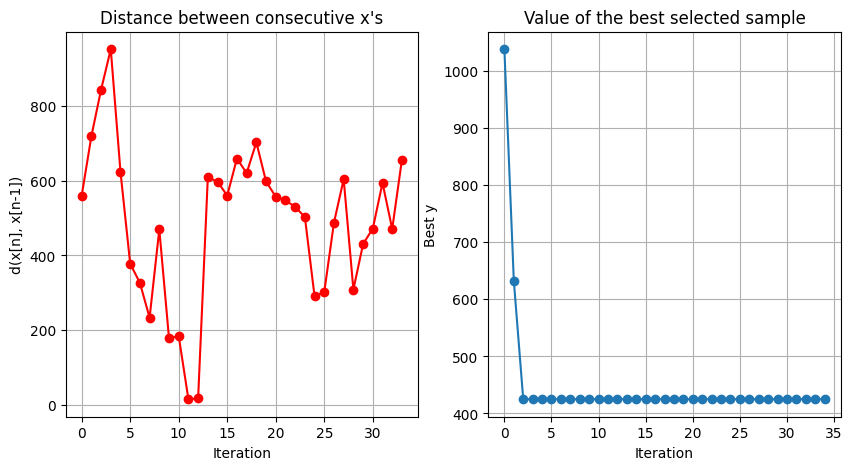

In [ ]:
b_optimization.plot_convergence()

### Hyperparameter optimization for CNN+BiLSTM+Transformer

In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_len=None, embedding_dim=None,**kwargs):
        super(PositionalEncoding, self).__init__()
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

    def call(self, x):

        position_embedding = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        position_embedding[:, 0::2] = np.sin(position_embedding[:, 0::2])  # dim 2i
        position_embedding[:, 1::2] = np.cos(position_embedding[:, 1::2])  # dim 2i+1
        position_embedding = tf.cast(position_embedding, dtype=tf.float32)

        return position_embedding+x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_len' : self.sequence_len,
            'embedding_dim' : self.embedding_dim,
        })
        return config

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate):
        # embed_dim: Embedding size for each token
        # num_heads: Number of attention heads
        # ff_dim: Hidden layer size in feed forward network inside transformer

        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-3)
        self.layernorm2 = LayerNormalization(epsilon=1e-3)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def Transformer_model(input_shape, num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                      dropout_rate_dense, dropout_rate_transformer, lstm1_unit, lstm2_unit,
                      num_heads, ff_dim, dense1_unit, dense2_unit, dense3_unit):
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filter, kernel_size, activation="relu")(inputs)
    pool1 = AveragePooling1D(2)(conv1)
    drop1 = Dropout(dropout_rate_conv)(pool1)

    conv2 = Conv1D(num_filter, kernel_size, activation="relu")(drop1)
    pool2 = AveragePooling1D(2)(conv2)
    drop2 = Dropout(dropout_rate_conv)(pool2)

    lstm1 = Bidirectional(LSTM(lstm1_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(drop2)
    lstm2 = Bidirectional(LSTM(lstm2_unit,
                               dropout=dropout_rate_lstm,
                               activation='tanh',
                               return_sequences=True,
                               kernel_regularizer=regularizers.l2(1e-4)))(lstm1)

    pos_embedding = PositionalEncoding(sequence_len=int(((34-kernel_size+1)/2-kernel_size+1)/2), embedding_dim=2*lstm2_unit)(lstm2)
    trans = TransformerBlock(2*lstm2_unit, num_heads, ff_dim, dropout_rate_transformer)(pos_embedding)
    avgpool = GlobalAveragePooling1D()(trans)

    dense1 = Dense(dense1_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(avgpool)
    drop3 = Dropout(dropout_rate_dense)(dense1)

    dense2 = Dense(dense2_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop3)
    drop4 = Dropout(dropout_rate_dense)(dense2)

    dense3 = Dense(dense3_unit,
                   kernel_regularizer=regularizers.l2(1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activation="relu")(drop4)
    drop5 = Dropout(dropout_rate_dense)(dense3)

    output = Dense(1, activation="linear")(drop5)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [ ]:
def HPO_with_CV(args):
    learning_rate = args[0][0]
    batch_size = int(args[0][1])
    num_filter = int(args[0][2])
    kernel_size = int(args[0][3])
    dropout_rate_conv = args[0][4]
    dropout_rate_lstm = args[0][5]
    dropout_rate_dense = args[0][6]
    dropout_rate_transformer = args[0][7]
    lstm1_unit = int(args[0][8])
    lstm2_unit = int(args[0][9])
    num_heads = int(args[0][10])
    ff_dim = int(args[0][11])
    dense1_unit = int(args[0][12])
    dense2_unit = int(args[0][13])
    dense3_unit = int(args[0][14])

    k_folds = 10
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1234)
    #fold_no = 1

    loss_per_fold = []
    #print(f'learning_rate:{learning_rate}\tbatch_size:{batch_size}\tnum_filter:{num_filter}\tkernel_size:{kernel_size}\tdropout_rate:{dropout_rate}\tlstm_unit:{lstm_unit}\tembed_dim:{embed_dim}\tnum_heads:{num_heads}\tff_dim:{ff_dim}\tdense1_unit:{dense1_unit}\tdense2_unit:{dense2_unit}\tdense3_unit:{dense3_unit}')
    print('Start training...')

    for train_index, val_index in kfold.split(Seq):
        X_train, X_val = Seq[train_index], Seq[val_index]
        y_train, y_val = Target[train_index], Target[val_index]

        model = Transformer_model((34,4), num_filter, kernel_size, dropout_rate_conv, dropout_rate_lstm,
                                  dropout_rate_dense, dropout_rate_transformer, lstm1_unit, lstm2_unit,
                                  num_heads, ff_dim, dense1_unit, dense2_unit, dense3_unit)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

        #print(f'Training for fold {fold_no} ...')
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, reduce_lr])

        scores = model.evaluate(X_val, y_val, verbose=0)
        loss_per_fold.append(scores[1])

        #fold_no += 1

    avg_mse = np.mean(loss_per_fold)
    print('Avg validation MSE:', avg_mse)
    return avg_mse


In [ ]:
lr_domain = [0.01, 0.001, 0.0001]
batch_domain = [32, 64, 128, 256, 512]
num_filter_domain = [64, 128, 256, 512]
kernel_size_domain = [3, 5]
dropout_conv_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_lstm_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_dense_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
dropout_transformer_domain = [0.1, 0.2, 0.3, 0.4, 0.5]
lstm1_unit_domain = [4, 8, 16, 32, 64, 128]
lstm2_unit_domain = [4, 8, 16, 32, 64, 128]
num_heads_domain = [2, 4, 6]
ff_dim_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense1_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense2_domain = [4, 8, 16, 32, 64, 128, 256, 512]
dense3_domain = [4, 8, 16, 32, 64, 128, 256, 512]

domain = [
    {"name": "learning_rate", "type": "discrete", "domain": lr_domain},
    {"name": "batch_size", "type": "discrete", "domain": batch_domain},
    {"name": "num_filter", "type": "discrete", "domain": num_filter_domain},
    {"name": "kernel_size", "type": "discrete", "domain": kernel_size_domain},
    {"name": "dropout_rate_conv", "type": "discrete", "domain": dropout_conv_domain},
    {"name": "dropout_rate_lstm", "type": "discrete", "domain": dropout_lstm_domain},
    {"name": "dropout_rate_dense", "type": "discrete", "domain": dropout_dense_domain},
    {"name": "dropout_rate_transformer", "type": "discrete", "domain": dropout_transformer_domain},
    {"name": "lstm1_unit", "type": "discrete", "domain": lstm1_unit_domain},
    {"name": "lstm2_unit", "type": "discrete", "domain": lstm2_unit_domain},
    {"name": "num_heads", "type": "discrete", "domain": num_heads_domain},
    {"name": "ff_dim", "type": "discrete", "domain": ff_dim_domain},
    {"name": "dense1_domain", "type": "discrete", "domain": dense1_domain},
    {"name": "dense2_domain", "type": "discrete", "domain": dense2_domain},
    {"name": "dense3_domain", "type": "discrete", "domain": dense3_domain}
]

In [ ]:
# Initialize Bayesian optimization
b_optimization = BayesianOptimization(
    HPO_with_CV,
    domain=domain,
    model_type="GP",
    acquisition_type="EI",
    verbosity=True,
    num_cores=32
)

# Run optimization
b_optimization.run_optimization(max_iter=30)

Start training...
Avg validation MSE: 1002.7385070800781
Start training...
Avg validation MSE: 478.4451446533203
Start training...
Avg validation MSE: 434.9410766601562
Start training...
Avg validation MSE: 1047.049627685547
Start training...
Avg validation MSE: 482.6445373535156
Start training...
Avg validation MSE: 859.9835510253906
Start training...
Avg validation MSE: 923.496859741211
Start training...
Avg validation MSE: 1038.4079528808593
Start training...
Avg validation MSE: 1038.5059814453125
Start training...
Avg validation MSE: 950.2470031738281
Start training...
Avg validation MSE: 1187.4489318847657
Start training...
Avg validation MSE: 1039.7943359375
Start training...
Avg validation MSE: 1038.4231689453125
Start training...
Avg validation MSE: 1038.396063232422
Start training...
Avg validation MSE: 987.46220703125
Start training...
Avg validation MSE: 436.58876953125
Start training...
Avg validation MSE: 457.5756378173828
Start training...
Avg validation MSE: 1044.7924072

In [ ]:
b_optimization.x_opt, b_optimization.fx_opt

(array([1.00e-04, 6.40e+01, 5.12e+02, 5.00e+00, 4.00e-01, 2.00e-01,
        1.00e-01, 3.00e-01, 3.20e+01, 6.40e+01, 2.00e+00, 2.56e+02,
        5.12e+02, 2.56e+02, 1.60e+01]),
 417.9654296875)

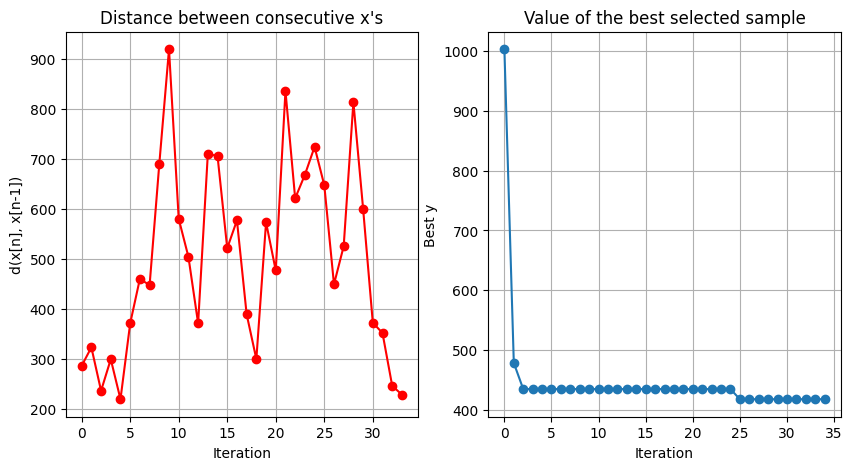

In [ ]:
b_optimization.plot_convergence()